In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [2]:
data = list()
tools=["optitype","arcas","rna2hla","hlaforest","seq2hla","hlahd","phlat","hlavbseq",'hlaminer',"T1K"]
#datasets=["1","d2","d3","d4","d5","d6"]
for t in tools:
    total = []
    for d in range(1,7):
        gs=pd.read_csv("../datasets/"+str(d)+"_gs.csv")
        pre=pd.read_csv("../results/standard/"+str(t)+"_d"+str(d)+".csv")
        ret=compute_matches(pre,gs)
        print(t,"d"+str(d),ret)
        total.append(ret)
    data.append(total)

optitype d1 ([10, 0], [28, 0], [2892, 0])
optitype d2 ([0, 0], [0, 0], [0, 0])
optitype d3 ([6, 0], [8, 0], [280, 0])
optitype d4 ([0, 0], [0, 0], [0, 0])
optitype d5 ([0, 0], [0, 0], [8, 0])
optitype d6 ([4, 0], [0, 0], [4, 0])
arcas d1 ([35, 6], [98, 99], [2711, 1801])
arcas d2 ([0, 4], [0, 5], [0, 163])
arcas d3 ([8, 0], [59, 0], [189, 0])
arcas d4 ([0, 0], [0, 0], [0, 4])
arcas d5 ([0, 0], [0, 0], [8, 0])
arcas d6 ([3, 0], [0, 0], [5, 0])
rna2hla d1 ([34, 45], [81, 33], [2779, 898])
rna2hla d2 ([0, 14], [0, 23], [0, 127])
rna2hla d3 ([12, 0], [21, 0], [257, 0])
rna2hla d4 ([0, 20], [0, 1], [0, 5])
rna2hla d5 ([0, 0], [2, 0], [6, 0])
rna2hla d6 ([4, 0], [1, 0], [3, 0])
hlaforest d1 ([86, 36], [338, 201], [2264, 1663])
hlaforest d2 ([0, 5], [0, 26], [0, 141])
hlaforest d3 ([20, 0], [31, 0], [233, 0])
hlaforest d4 ([0, 10], [0, 4], [0, 10])
hlaforest d5 ([0, 0], [0, 0], [8, 0])
hlaforest d6 ([4, 0], [2, 0], [2, 0])
seq2hla d1 ([34, 111], [81, 186], [2779, 1649])
seq2hla d2 ([0, 52], [

ParserError: Error tokenizing data. C error: Expected 28 fields in line 4, saw 29


In [4]:
# sorting through code to calculate Class I and Class II accuracy
data = np.array(data)

classIresults = []
classIIresults = []
allresults = []

for tool in data:
    r = np.sum(np.array(tool),axis=0)
    allresults.append(r[:,0]+r[:,1])
    classIresults.append(r[:,0])
    classIIresults.append(r[:,1])

# normalizing accuracies to 1
classIresults = np.array(classIresults)
row_sums = classIresults.sum(axis=1)
classIresults = classIresults / row_sums[:, np.newaxis]


classIIresults = np.array(classIIresults)
row_sums = classIIresults.sum(axis=1)
classIIresults = classIIresults / row_sums[:, np.newaxis]
np.nan_to_num(classIIresults,0)

allresults = np.array(allresults)
row_sums = allresults.sum(axis=1)
allresults = allresults / row_sums[:, np.newaxis]


print(classIresults)
print(classIIresults)
print(allresults)



[[0.00617284 0.01111111 0.98271605]
 [0.01476252 0.05038511 0.93485237]
 [0.015625   0.0328125  0.9515625 ]
 [0.03681392 0.12416332 0.83902276]
 [0.015625   0.0328125  0.9515625 ]
 [0.05876807 0.04651163 0.8947203 ]
 [0.02717747 0.06123117 0.91159136]
 [0.09987072 0.05138979 0.8487395 ]
 [0.85129461 0.08502449 0.0636809 ]]
[[0.         0.         0.        ]
 [0.01614435 0.04938272 0.93447293]
 [0.067753   0.04888508 0.88336192]
 [0.02433206 0.11020992 0.86545802]
 [0.0858349  0.09427767 0.81988743]
 [0.06238274 0.03001876 0.9075985 ]
 [0.10927573 0.06416773 0.82655654]
 [0.92634561 0.01369216 0.05996223]
 [0.73690078 0.15886288 0.10423634]]
[[0.00617284 0.01111111 0.98271605]
 [0.0153198  0.04998085 0.93469935]
 [0.0295465  0.0371049  0.9333486 ]
 [0.03166798 0.1184107  0.84992132]
 [0.04369842 0.05738935 0.89891223]
 [0.06021829 0.03989462 0.89988709]
 [0.05509939 0.0622299  0.8826707 ]
 [0.43572525 0.03607061 0.52820414]
 [0.80717971 0.11349957 0.07932072]]


/var/folders/j4/pd1pbcl90xz683wfkd2drjqw0000gn/T/ipykernel_62598/2963043930.py:22: RuntimeWarning: invalid value encountered in true_divide
  classIIresults = classIIresults / row_sums[:, np.newaxis]


In [5]:
pd.DataFrame(allresults,index=tools)

,0,1,2
optitype,0.006173,0.011111,0.982716
arcas,0.015320,0.049981,0.934699
rna2hla,0.029546,0.037105,0.933349
hlaforest,0.031668,0.118411,0.849921
seq2hla,0.043698,0.057389,0.898912
hlahd,0.060218,0.039895,0.899887
phlat,0.055099,0.062230,0.882671
hlavbseq,0.435725,0.036071,0.528204
hlaminer,0.807180,0.113500,0.079321


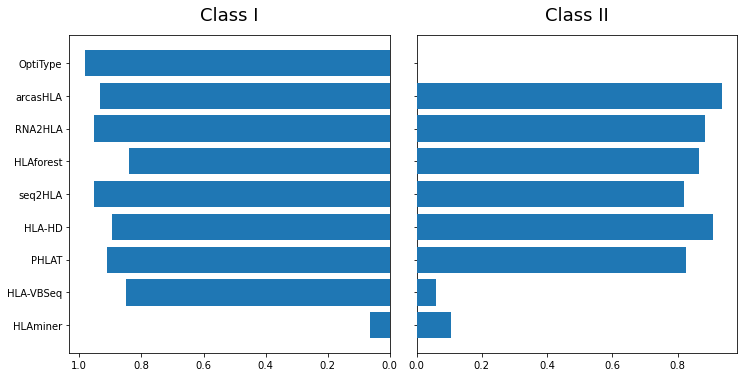

In [6]:
# plotting 0 4dig accuracy

index = ["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq","HLAminer"]
title0 = 'Class I'
title1 = 'Class II'

fourdig_I = classIresults[:,2]
fourdig_II = classIIresults[:,2]

fig, axes = plt.subplots(figsize=(10,5),  ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, fourdig_I, align='center',zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15)
axes[1].barh(index, fourdig_II, align='center', zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15)


axes[0].invert_xaxis() 
plt.gca().invert_yaxis()

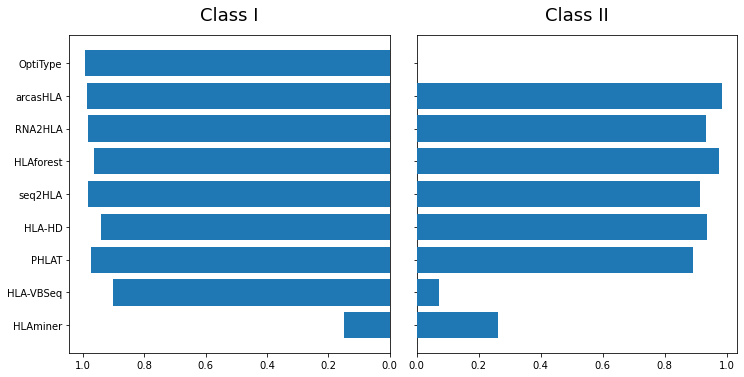

In [7]:
# plotting 2 dig accuracy


index = ["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq","HLAminer"]
title0 = 'Class I'
title1 = 'Class II'
twodig_I = classIresults[:,1]+classIresults[:,2]
twodig_II = classIIresults[:,1]+classIIresults[:,2]


fig, axes = plt.subplots(figsize=(10,5),  ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, twodig_I, align='center',zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15)
axes[1].barh(index, twodig_II, align='center', zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15)


axes[0].invert_xaxis() 
plt.gca().invert_yaxis()

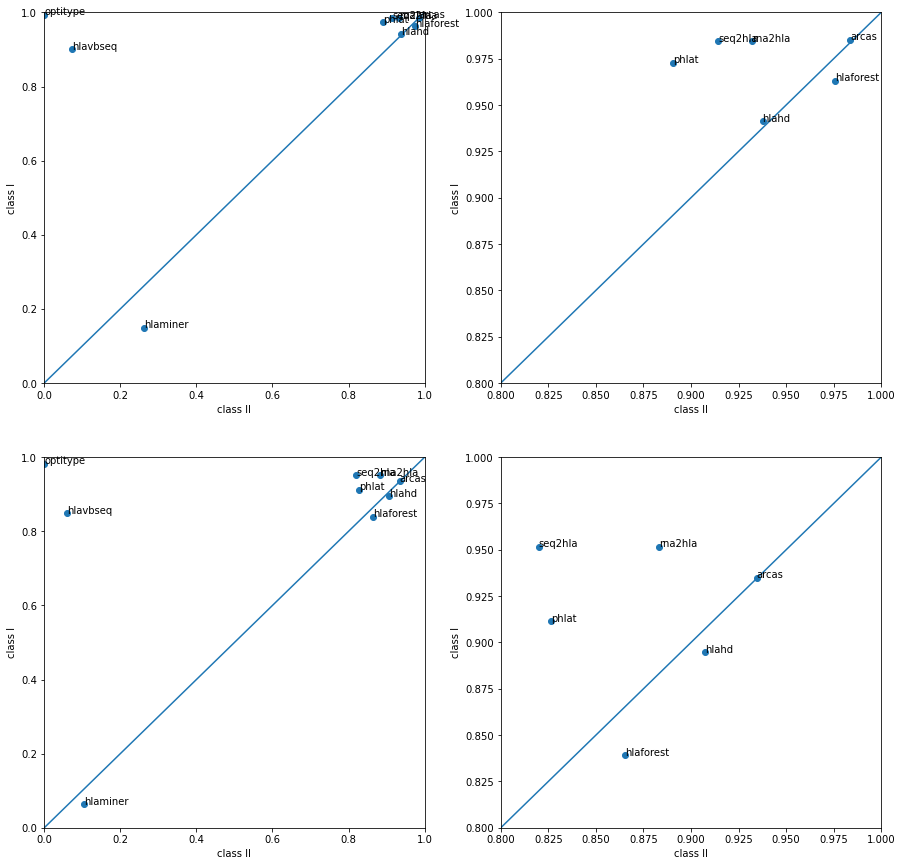

In [8]:
fig, ax = plt.subplots(2, 2,figsize=(15, 15))


ax[0][0].scatter(twodig_II,twodig_I)
for i, txt in enumerate(tools):
    ax[0][0].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][0].set_xlim([0,1])
ax[0][0].set_ylim([0,1])
ax[0][0].set_xlabel("class II")
ax[0][0].set_ylabel("class I")
ax[0][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[0][1].scatter(twodig_II,twodig_I)
for i, txt in enumerate(tools):
    ax[0][1].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][1].set_xlim([0.8,1])
ax[0][1].set_ylim([0.8,1])
ax[0][1].set_xlabel("class II")
ax[0][1].set_ylabel("class I")
ax[0][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[1][0].scatter(fourdig_II,fourdig_I)
for i, txt in enumerate(tools):
    ax[1][0].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][0].set_xlim([0,1])
ax[1][0].set_ylim([0,1])
ax[1][0].set_xlabel("class II")
ax[1][0].set_ylabel("class I")
ax[1][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[1][1].scatter(fourdig_II,fourdig_I)
for i, txt in enumerate(tools):
    ax[1][1].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][1].set_xlim([0.8,1])
ax[1][1].set_ylim([0.8,1])
ax[1][1].set_xlabel("class II")
ax[1][1].set_ylabel("class I")
ax[1][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


In [9]:
labels=["OptiType","arcasHLA","RNA2HLA","HLAforest","Seq2HLA","HLA-HD","PHLAT","HLA-VBSeq",'HLAminer']

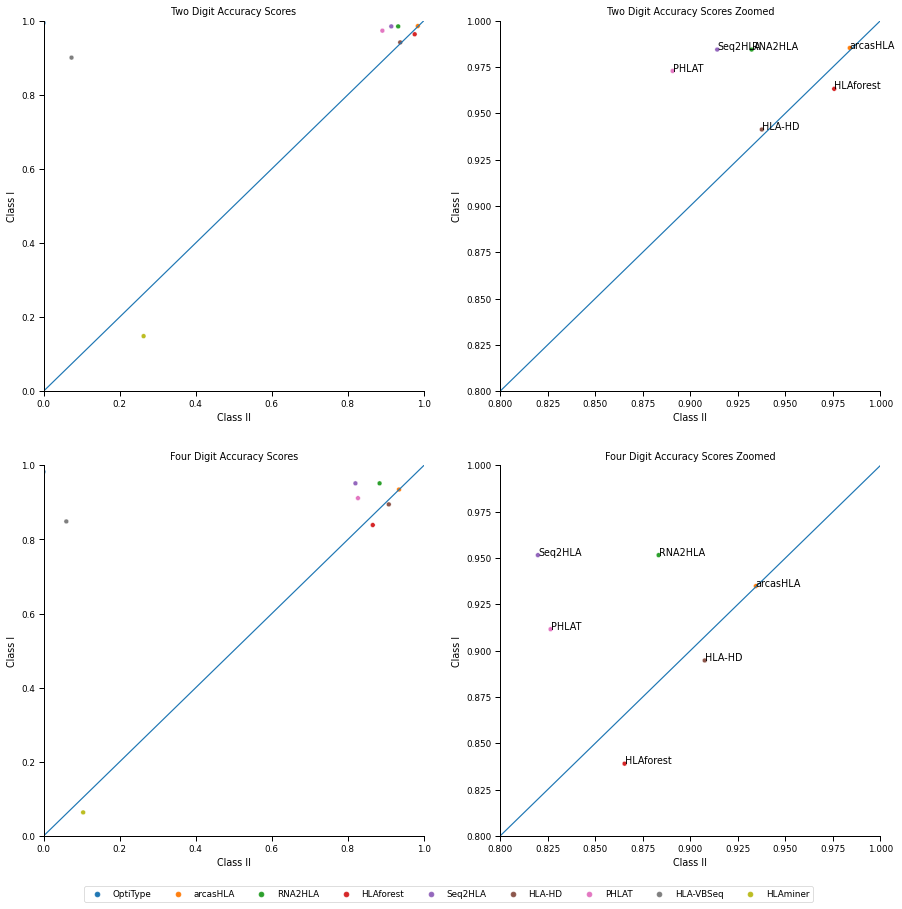

In [10]:
sns.set_context("paper")
sns.color_palette("pastel")
fig, ax = plt.subplots(2, 2,figsize=(15, 15))
sns.scatterplot(ax=ax[0][0],x=twodig_II, y=twodig_I,hue=labels,legend=False)
#for i, txt in enumerate(labels):
#    ax[0][0].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
ax[0][0].set_xlim([0,1])
ax[0][0].set_ylim([0,1])
ax[0][0].set_xlabel("Class II")
ax[0][0].set_ylabel("Class I")
ax[0][0].set(title='Two Digit Accuracy Scores')

sns.scatterplot(ax=ax[0][1],x=twodig_II, y=twodig_I,hue=labels,legend=False)
for i, txt in enumerate(labels):
    ax[0][1].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
ax[0][1].set_xlim([0.8,1])
ax[0][1].set_ylim([0.8,1])
ax[0][1].set_xlabel("Class II")
ax[0][1].set_ylabel("Class I")
ax[0][1].set(title='Two Digit Accuracy Scores Zoomed')

sns.scatterplot(ax=ax[1][0],x=fourdig_II, y=fourdig_I,hue=labels,legend=False)
#for i, txt in enumerate(labels):
#    ax[1][0].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
ax[1][0].set_xlim([0,1])
ax[1][0].set_ylim([0,1])
ax[1][0].set_xlabel("Class II")
ax[1][0].set_ylabel("Class I")
ax[1][0].set(title='Four Digit Accuracy Scores')

sns.scatterplot(ax=ax[1][1],x=fourdig_II, y=fourdig_I,hue=labels)
plt.legend([],[], frameon=False)
for i, txt in enumerate(labels):
    ax[1][1].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
ax[1][1].set_xlim([0.8,1])
ax[1][1].set_ylim([0.8,1])
ax[1][1].set_xlabel("Class II")
ax[1][1].set_ylabel("Class I")
ax[1][1].set(title='Four Digit Accuracy Scores Zoomed')
#handles, labels = ax[1][1].get_legend_handles_labels()
fig.legend(*ax[1][1].get_legend_handles_labels(), loc="lower center",ncol=9,bbox_to_anchor=(0.50,0.06))
sns.despine()
